# Fraud Detection Model Using Clustering and Anomaly Detection
#### by Seyed Vala Khorasani
##### November 2024

## Importing the Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')


## Loading the Dataset

In [2]:
df = pd.read_csv("/kaggle/input/bank-transaction-dataset-for-fraud-detection/bank_transactions_data_2.csv")

In [3]:
df

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,TX002508,AC00297,856.21,2023-04-26 17:09:36,Credit,Colorado Springs,D000625,21.157.41.17,M072,Branch,33,Doctor,109,1,12690.79,2024-11-04 08:11:29
2508,TX002509,AC00322,251.54,2023-03-22 17:36:48,Debit,Tucson,D000410,49.174.157.140,M029,Branch,48,Doctor,177,1,254.75,2024-11-04 08:11:42
2509,TX002510,AC00095,28.63,2023-08-21 17:08:50,Debit,San Diego,D000095,58.1.27.124,M087,Branch,56,Retired,146,1,3382.91,2024-11-04 08:08:39
2510,TX002511,AC00118,185.97,2023-02-24 16:24:46,Debit,Denver,D000634,21.190.11.223,M041,Online,23,Student,19,1,1776.91,2024-11-04 08:12:22


## General Overview

In [4]:
print("Dataset Shape:", df.shape)
print("\nColumn Data Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nFirst Few Rows:\n", df.head())
print("\nDescriptive Statistics:\n", df.describe())

Dataset Shape: (2512, 16)

Column Data Types:
 TransactionID               object
AccountID                   object
TransactionAmount          float64
TransactionDate             object
TransactionType             object
Location                    object
DeviceID                    object
IP Address                  object
MerchantID                  object
Channel                     object
CustomerAge                  int64
CustomerOccupation          object
TransactionDuration          int64
LoginAttempts                int64
AccountBalance             float64
PreviousTransactionDate     object
dtype: object

Missing Values:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDu

### Check Unique Value Counts for Key Identifiers

In [5]:
print("\nUnique Accounts:", df['AccountID'].nunique())
print("Unique Devices:", df['DeviceID'].nunique())
print("Unique Locations:", df['Location'].nunique())
print("Unique Merchants:", df['MerchantID'].nunique())


Unique Accounts: 495
Unique Devices: 681
Unique Locations: 43
Unique Merchants: 100


## Exploratory Data Analysis

### Transaction Amount Distribution

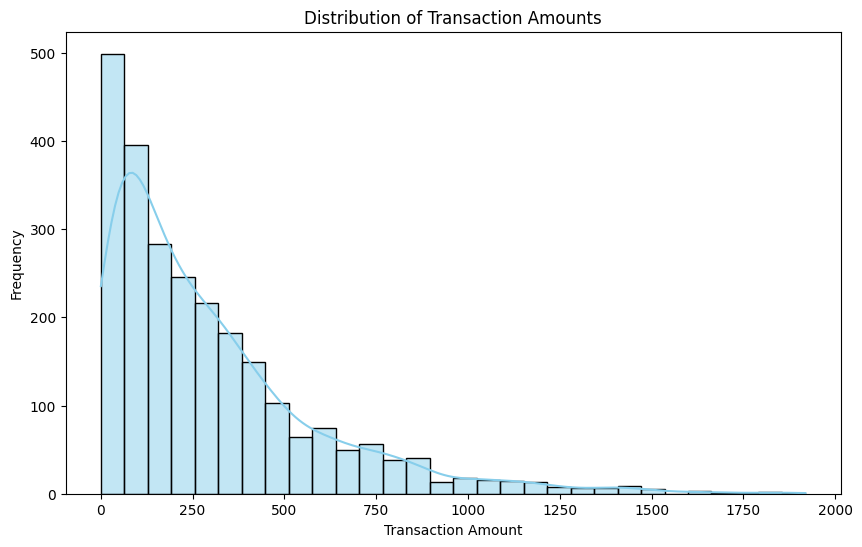

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['TransactionAmount'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()


### Distribution of Transaction Types

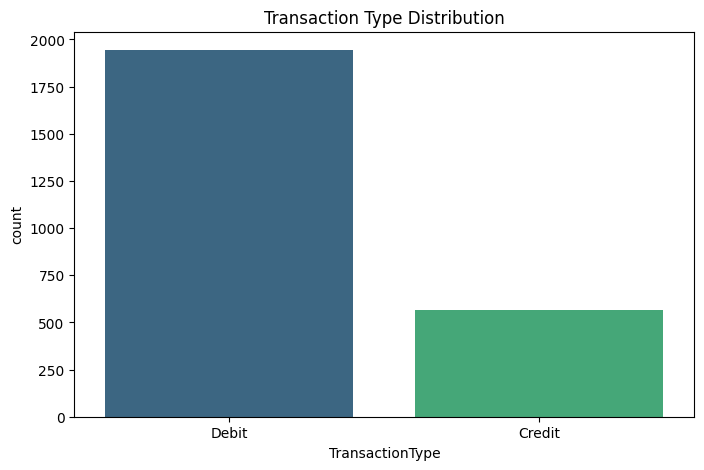

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='TransactionType', palette='viridis')
plt.title("Transaction Type Distribution")
plt.show()

### Transaction Amount Distribution and Outliers

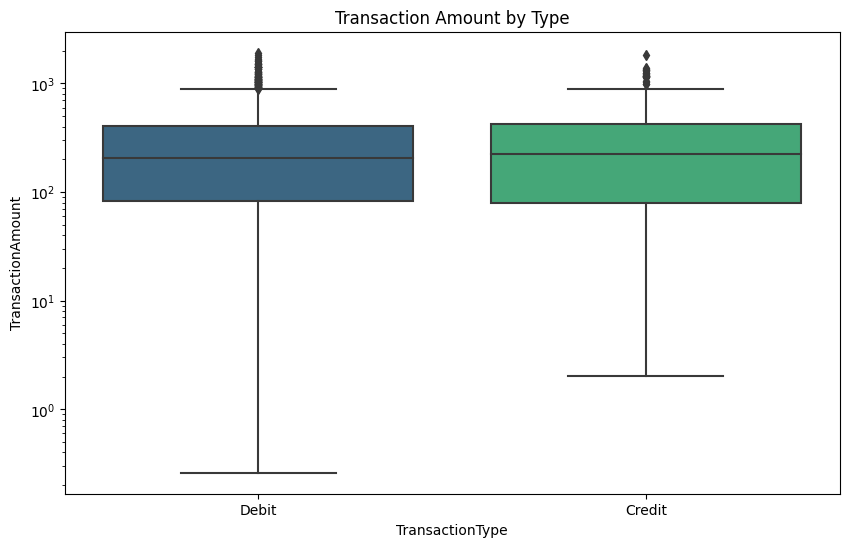

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='TransactionType', y='TransactionAmount', palette='viridis')
plt.yscale('log')  # Log scale to show outliers
plt.title("Transaction Amount by Type")
plt.show()

### Transaction Amount by Age Group (Customer Demographics)

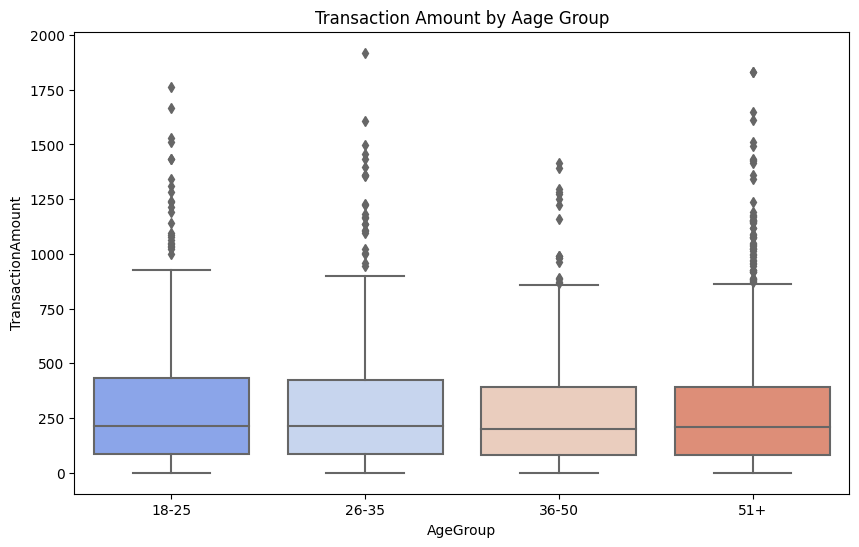

In [9]:
df['AgeGroup'] = pd.cut(df['CustomerAge'], bins=[0, 25, 35, 50, 100], labels=['18-25', '26-35', '36-50', '51+'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='AgeGroup', y='TransactionAmount', palette='coolwarm')
plt.title("Transaction Amount by Aage Group")
plt.show()

### Daily Transaction Count (Time-based Analysis)

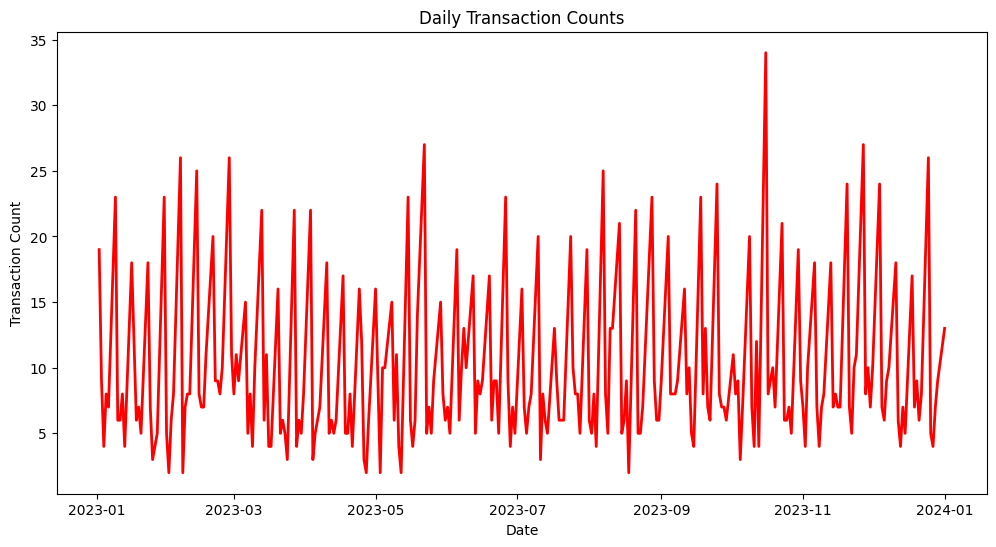

In [10]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionDay'] = df['TransactionDate'].dt.date
daily_counts = df.groupby('TransactionDay').size()
plt.figure(figsize=(12, 6))
daily_counts.plot(title="Daily Transaction Counts", color='red', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Transaction Count")
plt.show()

### Transaction Count by Day of the Week

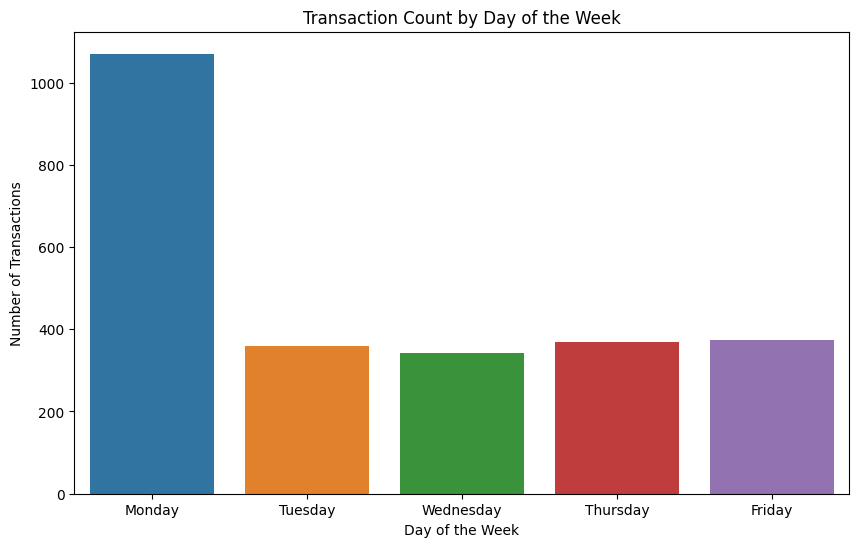

In [11]:
# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Extract the day of the week
df['DayOfWeek'] = df['TransactionDate'].dt.day_name()

# Plot transaction count by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='DayOfWeek', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Transaction Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.show()


### Analyzing Transaction Times for Anomalies

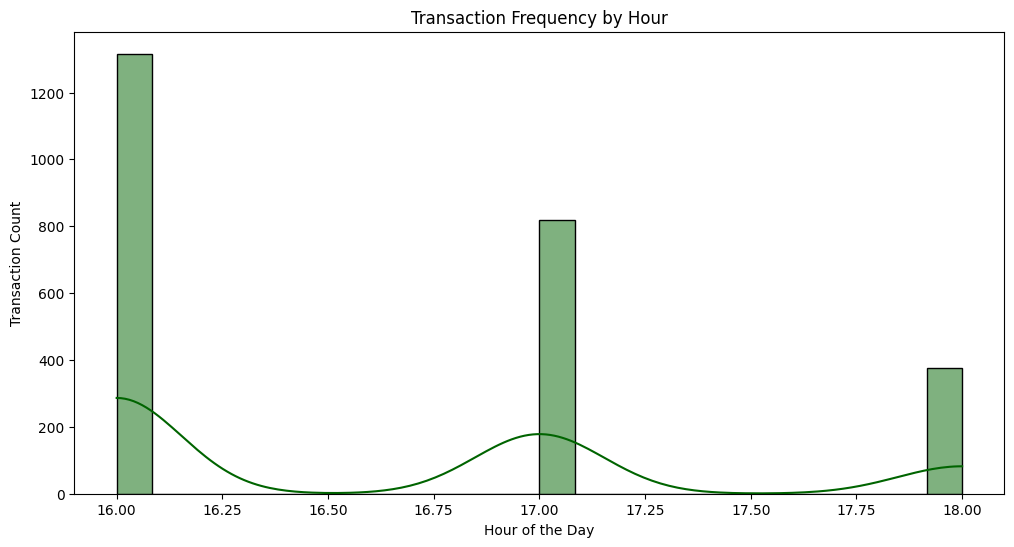

In [12]:
df['Hour'] = df['TransactionDate'].dt.hour
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Hour', kde=True, bins=24, color='darkgreen')
plt.title("Transaction Frequency by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Transaction Count")
plt.show()

### Top Locations by Transaction Volume

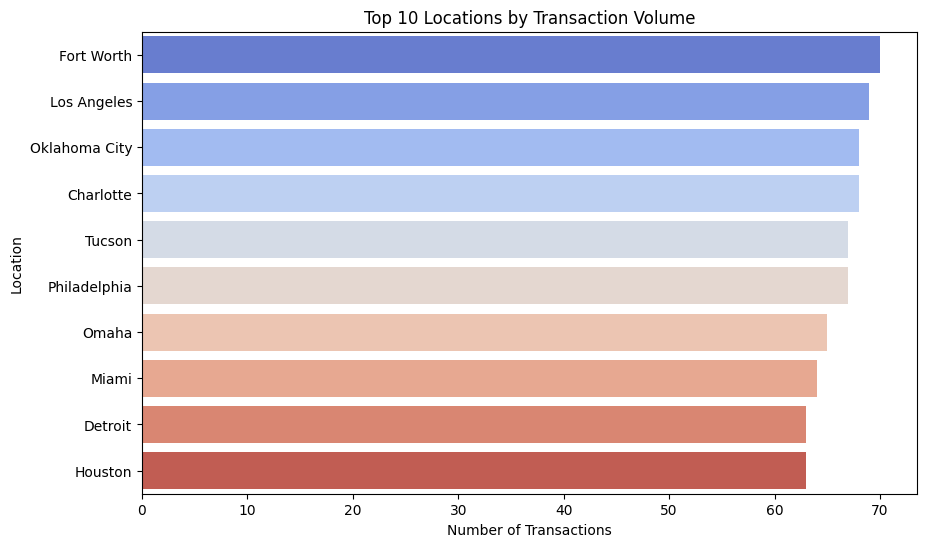

In [13]:
top_locations = df['Location'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_locations.index, x=top_locations.values, palette='coolwarm')
plt.title('Top 10 Locations by Transaction Volume')
plt.xlabel('Number of Transactions')
plt.ylabel('Location')
plt.show()


### Customer Age Distribution by Transaction Type

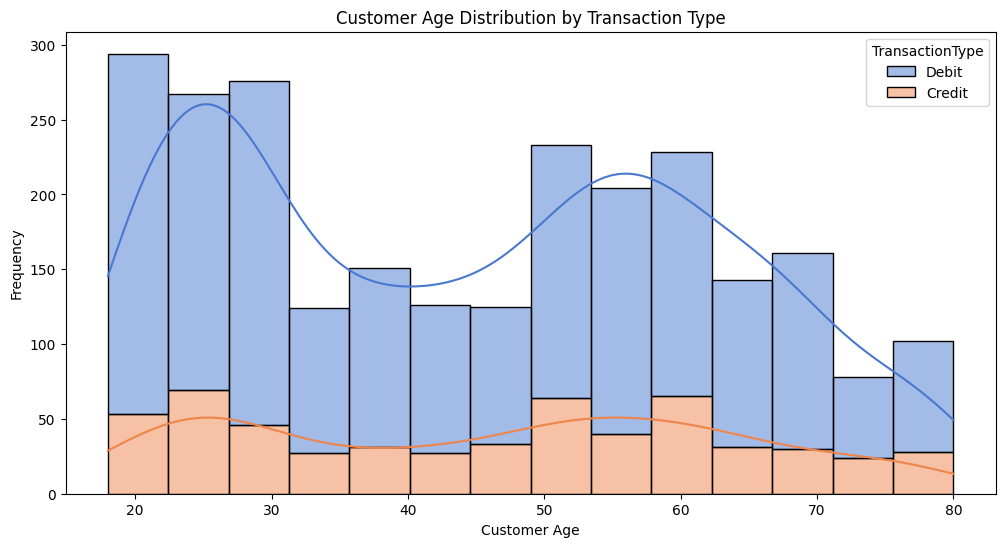

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='CustomerAge', hue='TransactionType', multiple='stack', palette='muted', kde=True)
plt.title('Customer Age Distribution by Transaction Type')
plt.xlabel('Customer Age')
plt.ylabel('Frequency')
plt.show()


### Account Balance vs. Transaction Amount

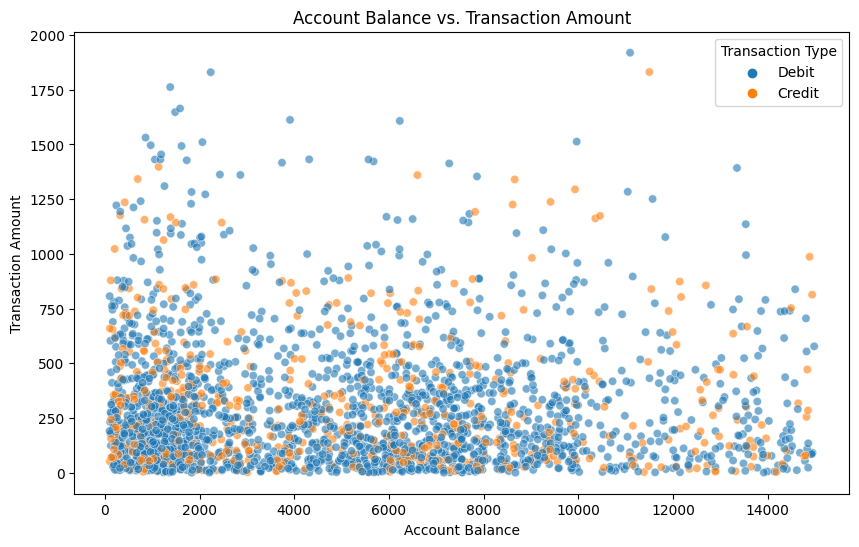

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='AccountBalance', y='TransactionAmount', hue='TransactionType', alpha=0.6)
plt.title('Account Balance vs. Transaction Amount')
plt.xlabel('Account Balance')
plt.ylabel('Transaction Amount')
plt.legend(title='Transaction Type')
plt.show()


### Correlation Analysis for Numeric Columns

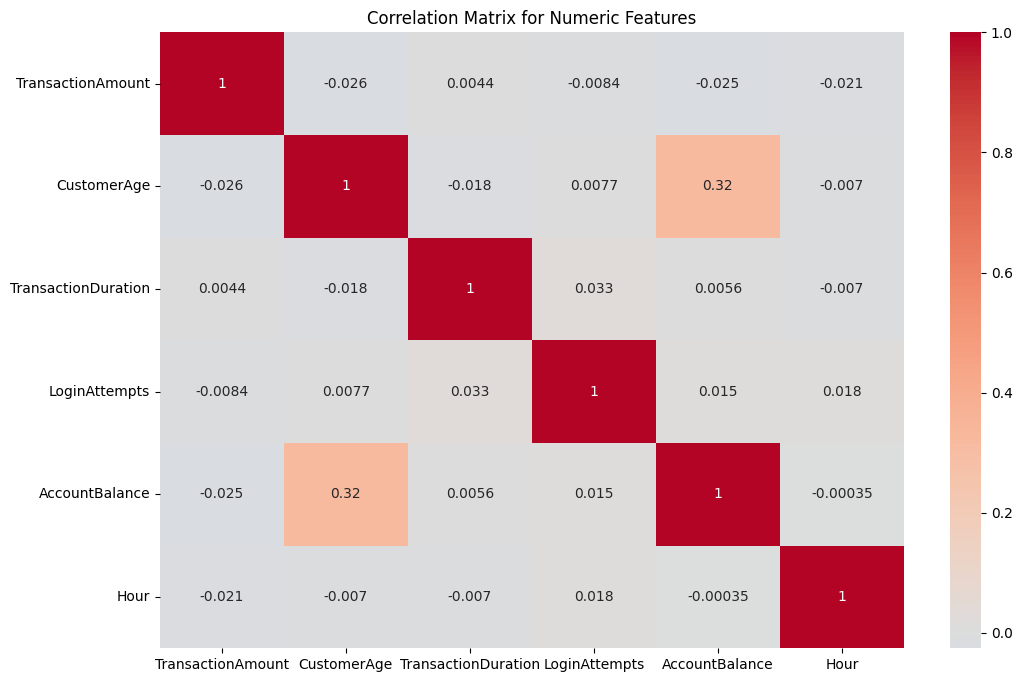

In [16]:
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix for Numeric Features")
plt.show()

### Login Attempts vs. Transaction Amount (Potential Fraud Indicator)

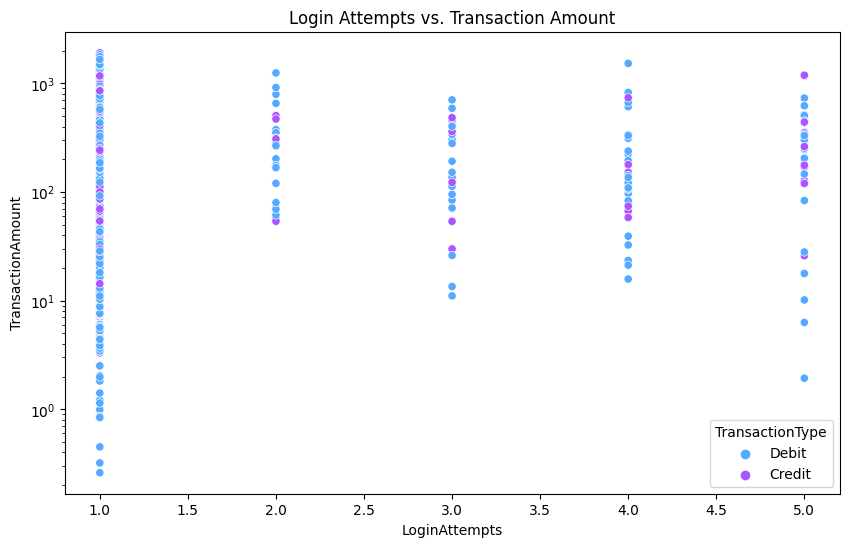

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='LoginAttempts', y='TransactionAmount', hue='TransactionType', palette='cool')
plt.yscale('log')
plt.title("Login Attempts vs. Transaction Amount")
plt.show()

 ### Time Gap Analysis (Transaction Frequency)

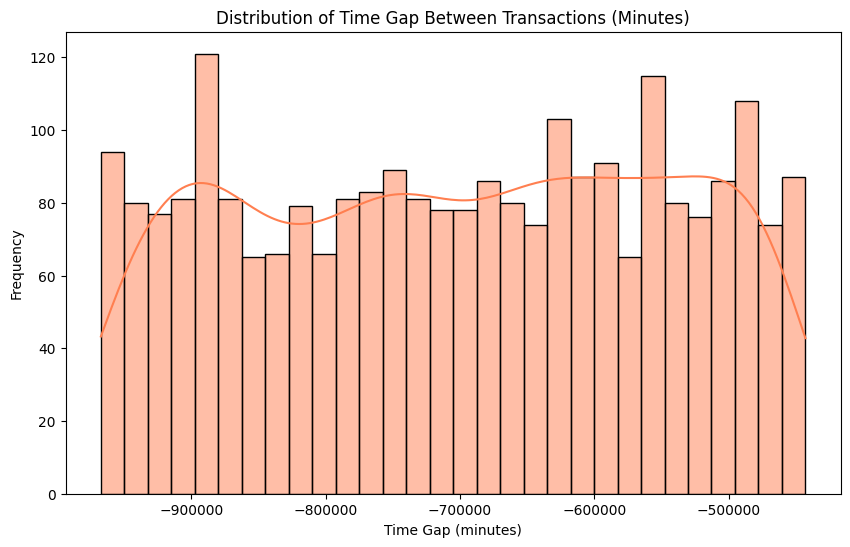

In [18]:
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])
df['TimeGap'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds() / 60
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='TimeGap', bins=30, color='coral', kde=True)
plt.title("Distribution of Time Gap Between Transactions (Minutes)")
plt.xlabel("Time Gap (minutes)")
plt.ylabel("Frequency")
plt.show()

### Channel Usage Patterns

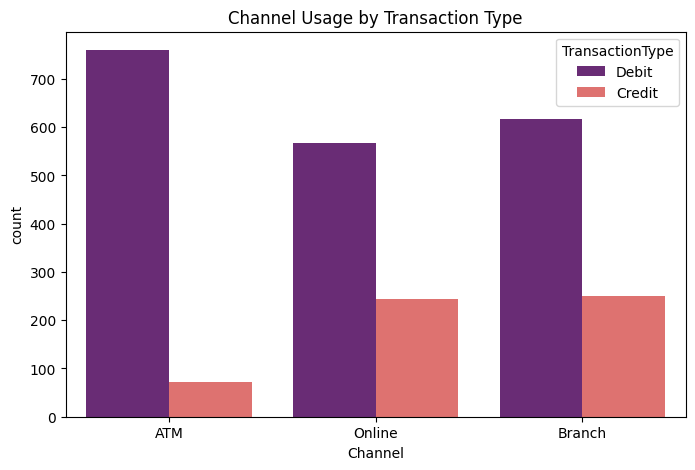

In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Channel', hue='TransactionType', palette='magma')
plt.title("Channel Usage by Transaction Type")
plt.show()

### DeviceID and IP Address Variation per Account (Anomaly Detection)

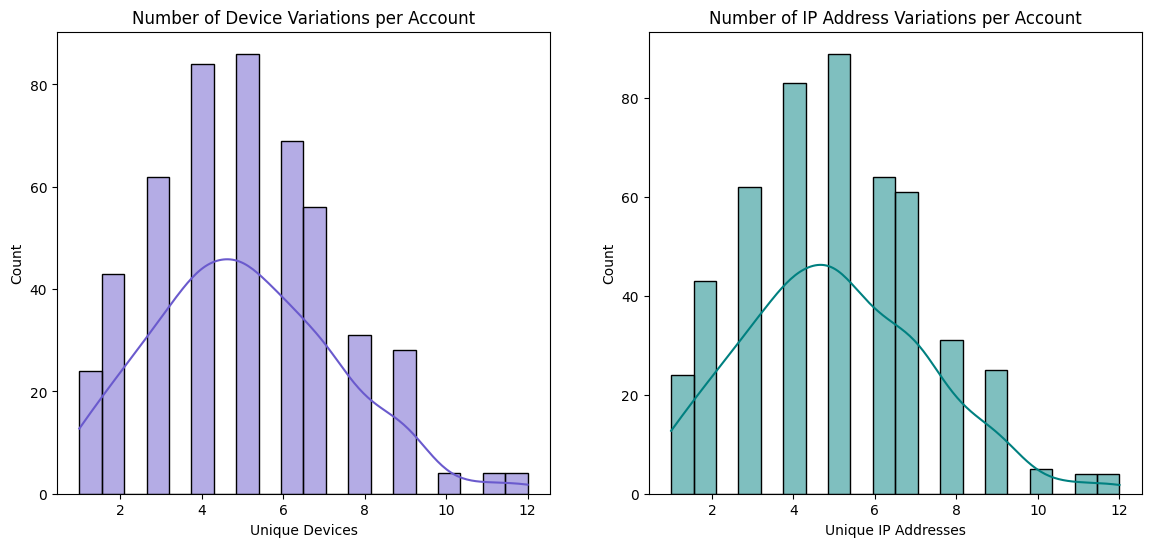

In [20]:
device_variations = df.groupby('AccountID')['DeviceID'].nunique()
ip_variations = df.groupby('AccountID')['IP Address'].nunique()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(device_variations, bins=20, color='slateblue', kde=True)
plt.title("Number of Device Variations per Account")
plt.xlabel("Unique Devices")
plt.subplot(1, 2, 2)
sns.histplot(ip_variations, bins=20, color='teal', kde=True)
plt.title("Number of IP Address Variations per Account")
plt.xlabel("Unique IP Addresses")
plt.show()

### Analyze Account Balance vs Transaction Amount

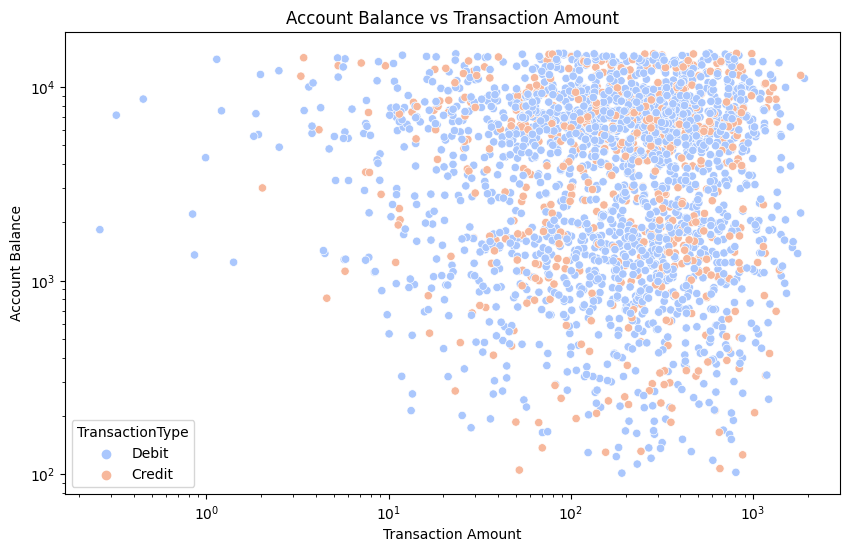

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='TransactionAmount', y='AccountBalance', hue='TransactionType', palette='coolwarm')
plt.xscale('log')
plt.yscale('log')
plt.title("Account Balance vs Transaction Amount")
plt.xlabel("Transaction Amount")
plt.ylabel("Account Balance")
plt.show()


### Merchant Trends (Most Frequent Merchants)

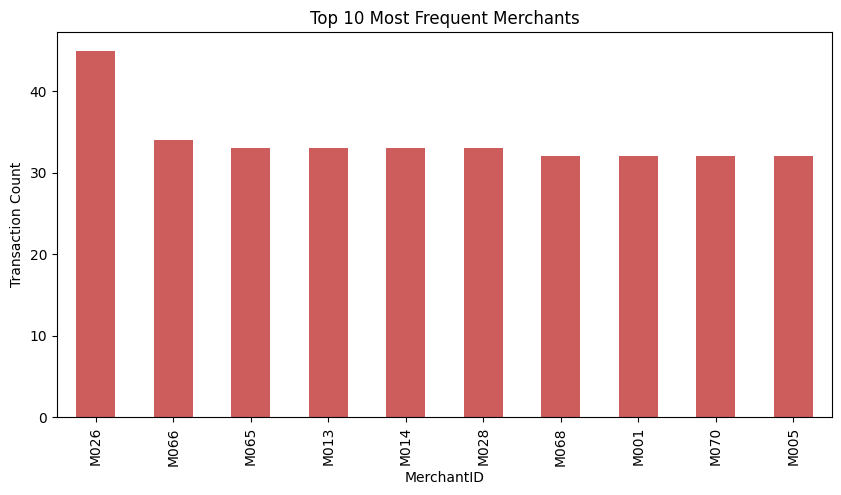

In [22]:
merchant_counts = df['MerchantID'].value_counts().head(10)
plt.figure(figsize=(10, 5))
merchant_counts.plot(kind='bar', color='indianred')
plt.title("Top 10 Most Frequent Merchants")
plt.xlabel("MerchantID")
plt.ylabel("Transaction Count")
plt.show()

### Chi-Square Test of Independence (Categorical Relationship)

In [23]:
contingency_table = pd.crosstab(df['TransactionType'], df['Channel'])
chi2, p, dof, ex = chi2_contingency(contingency_table)
print("\nChi-Square Test between TransactionType and Channel")
print(f"Chi2 Statistic: {chi2}, p-value: {p}")


Chi-Square Test between TransactionType and Channel
Chi2 Statistic: 136.90539694747218, p-value: 1.8679738038721596e-30


#### The Chi-Square Test of Independence is a statistical test used to determine if there is a significant association between two categorical variables. It helps answer questions like, "Are gender and product preference related?" or "Is transaction type associated with customer location?"

Since the p-value is so low, we can conclude with high confidence that there is a statistically significant association between TransactionType and Channel.

## K-means Clustering

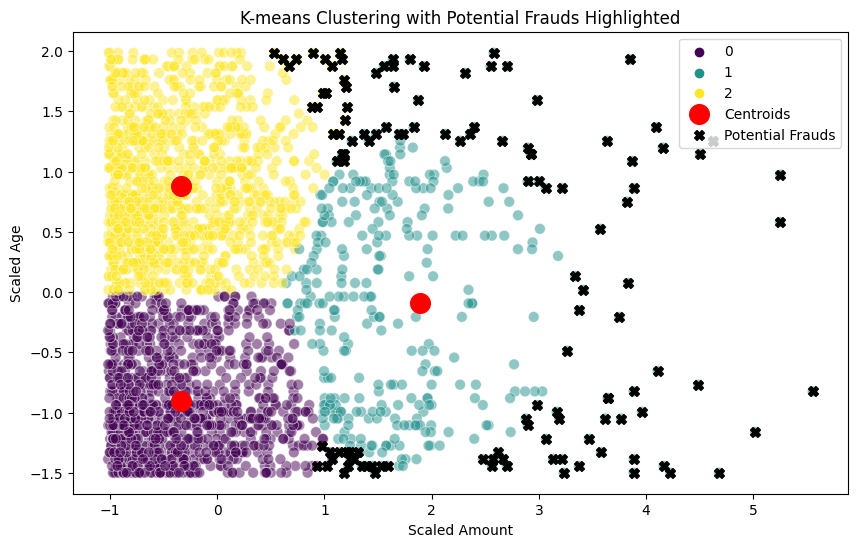

Number of potential frauds detected: 126


In [24]:


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


X = df[['TransactionAmount', 'CustomerAge']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add labels to the dataset
df['KMeans_Cluster'] = kmeans_labels


# Calculate distance of each point to its assigned cluster centroid
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)

# Define a threshold (e.g., top 5% farthest from centroids)
threshold = np.percentile(distances, 95)  # Change this value as needed

# Flag points above the threshold as potential frauds
df['Potential_Fraud'] = distances > threshold

# Separate fraudulent and non-fraudulent transactions
frauds = df[df['Potential_Fraud']]
non_frauds = df[~df['Potential_Fraud']]

# Plot with frauds highlighted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis', s=60, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', label='Centroids')
plt.scatter(X_scaled[distances > threshold, 0], X_scaled[distances > threshold, 1], 
            color='black', s=50, label='Potential Frauds', marker='X')
plt.title('K-means Clustering with Potential Frauds Highlighted')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend()
plt.show()

# Output the number of frauds detected
print(f"Number of potential frauds detected: {len(frauds)}")


## DBSCAN Clustering on Transactions

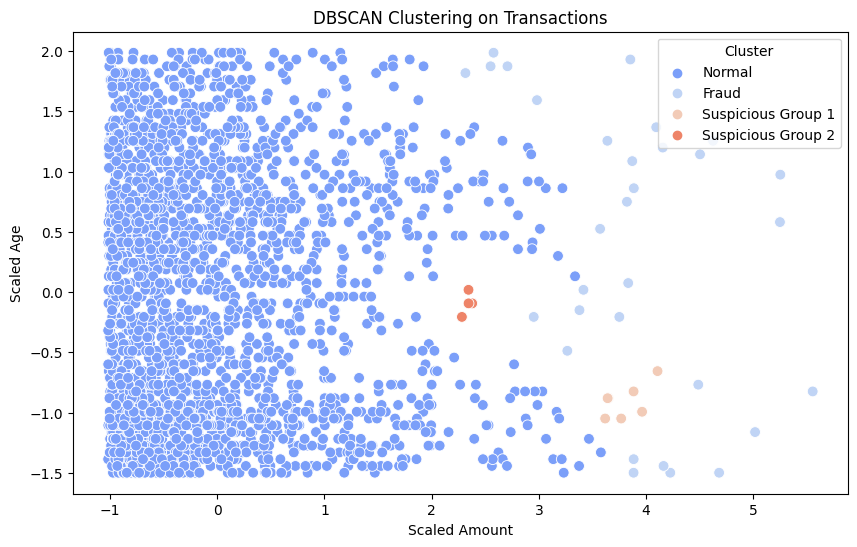

In [25]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

# Adjusted DBSCAN clustering with a refined eps value
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Adjust eps based on k-distance elbow
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add labels to the dataset
df['DBSCAN_Cluster'] = dbscan_labels

# Map the cluster labels to descriptive names
label_mapping = {-1: 'Fraud', 0: 'Normal', 1: 'Suspicious Group 1', 2: 'Suspicious Group 2'}
df['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].map(label_mapping)

# Plotting with updated labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['DBSCAN_Cluster'], palette='coolwarm', s=60)
plt.title('DBSCAN Clustering on Transactions')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Cluster')
plt.show()


## Hierarchical Clustering on Transactions

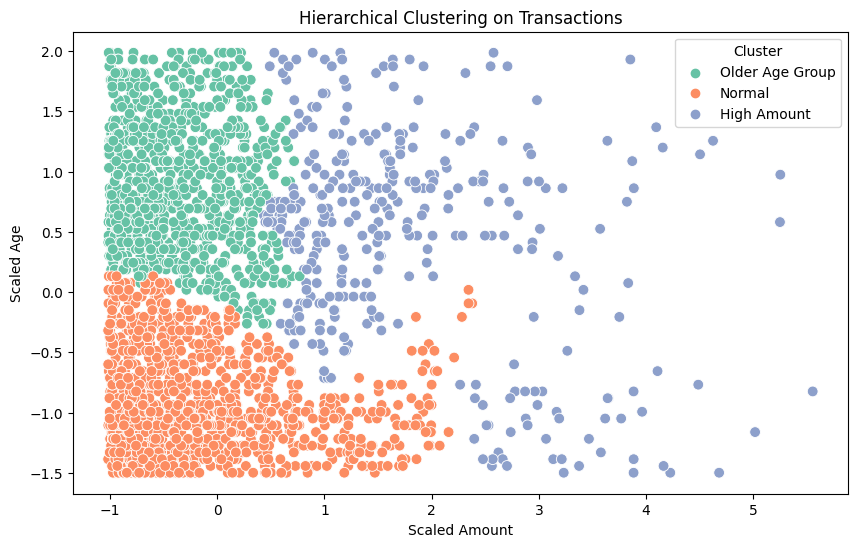

In [26]:
from sklearn.cluster import AgglomerativeClustering

# Hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add labels to the dataset
df['Hierarchical_Cluster'] = hierarchical_labels

# Mapping the cluster labels to descriptive names
cluster_mapping = {0: 'Normal', 1: 'High Amount', 2: 'Older Age Group'}
df['Hierarchical_Cluster'] = df['Hierarchical_Cluster'].map(cluster_mapping)

# Plot with updated labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['Hierarchical_Cluster'], palette='Set2', s=60)
plt.title('Hierarchical Clustering on Transactions')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Cluster')
plt.show()



## Isolation Forest for Anomaly Detection 

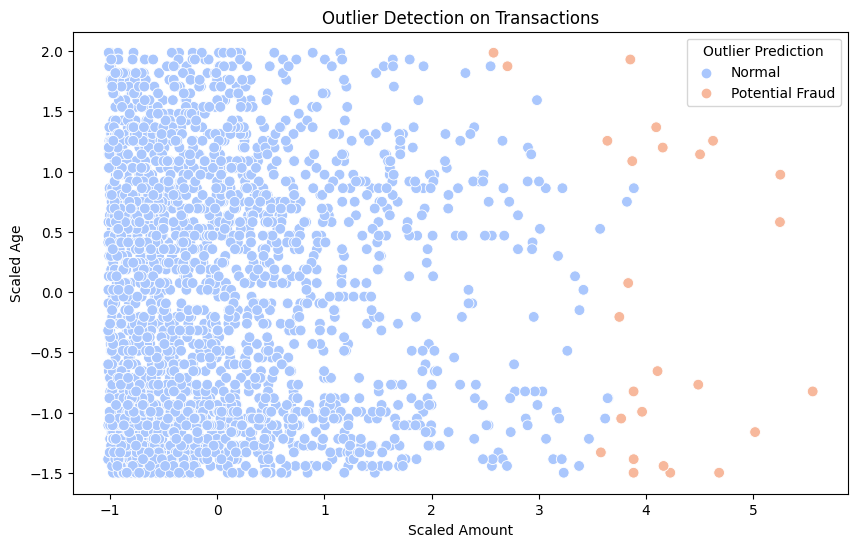

In [27]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest to identify anomalies
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Set contamination rate to expected fraud rate
outlier_pred = iso_forest.fit_predict(X_scaled)

# Map the results (-1 for outliers, 1 for normal) to descriptive labels
outlier_mapping = {1: 'Normal', -1: 'Potential Fraud'}
df['Outlier_Prediction'] = pd.Series(outlier_pred).map(outlier_mapping)

# Plotting with isolation forest outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['Outlier_Prediction'], palette='coolwarm', s=60)
plt.title('Outlier Detection on Transactions')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Age')
plt.legend(title='Outlier Prediction')
plt.show()
